# Mutating The Topology
In this notebook, we will consider mutating the topology of a network while simulating the network. For this purpose,
we will consider a very simple network consisting of a just two nodes whose dynamics are Lorenz dynamics defined by
$$
f([x, y, x]) = \left\{
\begin{aligned}
\dot{x} &= \sigma (y - x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} & = x y - \beta x \\
\end{aligned}
\right.
$$
The network can be represented more compactly as
$$
\dot{X} = F(X) + \epsilon (\Xi \otimes P) X
$$
where $ \Xi = [\xi_{ij}] $ is the outer coupling matrix that is determined by the network topology. For this simple
network we have
$$
\Xi = \begin{bmatrix}
-1 &  1 \\
 1 & -1 \\
\end{bmatrix}
In this use-case, we will control the coupling between the nodes.

Load the packages

In [1]:
using DifferentialEquations
using Plots
using LightGraphs, GraphPlot
using LinearAlgebra

Construct the network ODE problem

In [2]:
function lorenz(dx, x, u, t, σ=10, β=8/3, ρ=35)
    dx[1] = σ * (x[2] - x[1])
    dx[2] = x[1] * (ρ - x[3]) - x[2]
    dx[3] = x[1] * x[2] - β * x[3]
end

mutable struct Net2{T1}
    f::T1
    ϵ::Float64
    Ξ::Matrix{Float64}
    P::Matrix{Float64}
end

function (net::Net2)(dx, x, u, t)
    for i in Iterators.partition(1 : length(x), size(net.P, 1))
        net.f(view(dx, i), view(x, i), nothing, t)
    end
    dx .+= net.ϵ[1] * kron(net.Ξ, net.P) * x
end

ϵl = 0.     # Low level of coupling. The nodes are decoupled.
ϵh = 50.    # High level of coupling. The nodes are coupled .
ϵ = ϵh
graph = path_graph(2)
Ξ = -collect(laplacian_matrix(graph)) .|> float
P = diagm([1, 0, 0]) .|> float
n = size(Ξ, 1)
d = size(P, 1)
net = Net2(lorenz, ϵ, Ξ, P)
prob = ODEProblem(net, rand(n * d), (0., 100.));

For the control of the connection, we will construct to callbacks. We will start the simulation with the nodes
connected. Then, with the first callback, we will decoupled the nodes at $ t = 25 $. Then, the with the second
callback, we will couple the nodes again. When the nodes are coupled, they synchronize to each other, and when they
are decoupled the nodes desynchronize. Let us contruct the callbacks.

In [3]:
tc = 25.    # Decoupling callback time.
cond_couple(x, t, integ) = t == tc
act_couple!(integ) = (integ.f.f.ϵ = ϵl)
td = 40.    # Coupling callback time.
cond_decouple(x, t, integ) = t == td
act_decouple!(integ) = (integ.f.f.ϵ = ϵh)
cbs = CallbackSet(
    DiscreteCallback(cond_couple, act_couple!),
    DiscreteCallback(cond_decouple, act_decouple!)
);

Then, we solve the problem

In [4]:
sol = solve(prob, callback=cbs, tstops=[tc, td])

retcode: Success
Interpolation: automatic order switching interpolation
t: 2886-element Vector{Float64}:
   0.0
   0.011797409890979608
   0.01708301532348558
   0.027612916491166893
   0.036471503292801404
   0.04932824661024943
   0.06317901330088732
   0.08209104514313795
   0.10571552613971741
   0.13838266593995846
   ⋮
  99.75763455652826
  99.78709871459235
  99.81593484912376
  99.8440679918756
  99.87077987913156
  99.89992144661109
  99.93432590980741
  99.97109317345767
 100.0
u: 2886-element Vector{Vector{Float64}}:
 [0.819972982603141, 0.23642299197832384, 0.8058026331593191, 0.3096603834862466, 0.9340959750938118, 0.7838851863149587]
 [0.629388779124768, 0.5143676886263259, 0.7839093874516342, 0.5299111680627154, 1.10002799320067, 0.7648215889930602]
 [0.6102437823265546, 0.6231031822755365, 0.7747823596161563, 0.5777431879324245, 1.1944242190590546, 0.7574600635389305]
 [0.623515680218563, 0.8362598431485264, 0.7579754024179874, 0.6485859109844181, 1.4023741603290487, 0.

Now we can plot the time waveform of the nodes.

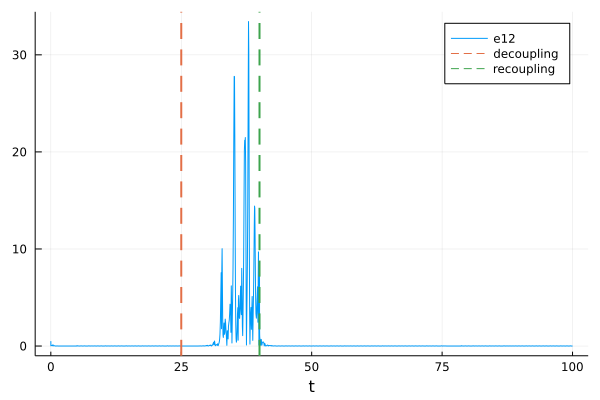

In [5]:
theme(:default)
t, x = sol.t, sol.u
plot(t, abs.(getindex.(x, 1) - getindex.(x, 4)), label="e12")
vline!([tc],linewidth = 2, linestyle=:dash, label="decoupling")
vline!([td],linewidth = 2, linestyle=:dash, label="recoupling")
xlabel!("t")

From the plot, we can see that the nodes synchronize when start the simulation. Then at $ t = 25 $, the coupling
between the nodes are disconnected. After this the nodes desynchronize. The, at $ t = 40 $ the nodes are connected
again, and the synchronization error goes to zero shortly .

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*